# Harmonizing Remote Sensing Data: Multimodal, Multi-Resolution Patch Extraction

## Introduction

In this notebook, we explore a fundamental data processing pipeline for **multimodal remote sensing data**. Our goal is to create **spatially consistent data samples** (patches) across different sensors (e.g., optical, thermal, SAR, DEM) that operate at **different resolutions**.

## Why This Matters

Remote sensing datasets often vary in **spatial resolution** (e.g., 10m, 30m) and **data type** (e.g., multispectral, radar). To integrate these diverse data sources effectively for **machine learning** or **environmental analysis**, we need to:

- **Generate spatially aligned samples** (patches) from all datasets  
- Ensure that these samples represent **the same geographic areas**, even though pixel sizes differ  
- Visualize and understand the **real-world spatial extent** of these patches—because a 224x224 patch in a 10m raster is **physically smaller** than the same-sized patch in a 30m raster!

## What You'll Learn

In this notebook, we'll cover:

- Generating patch center points within a defined boundary (e.g., a watershed)  
- Extracting patches from each dataset that align to these center points  
- Visualizing the **real-world footprint** of these patches across resolutions  
- Understanding how to prepare **multi-resolution, multimodal samples** for downstream ML models

Let’s get started!


### Setup & Imports

In [46]:
%pip install rasterio matplotlib geopandas shapely > /dev/null

1883.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [67]:
import os
import re
import rasterio
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import box, Point
from rasterio.plot import show
data_path = '../data/'

# Define patch size and stride
patch_size = 224
stride = 224

###  Raster Acquisition Process
For our geospatial analysis, we followed this workflow to acquire raster data for the study area:

1. Select the Watershed
We start by identifying the original watershed boundary from the GeoJSON file (shown in lime green in the figure).

2. Buffer the Watershed by 5 km
To ensure full spatial coverage of relevant features and to include surrounding influences, we apply a 5 km buffer around the watershed polygon (shown in red).

3. Compute the Bounding Box of the Buffered Area
To standardize data acquisition and ensure consistent raster extents, we calculate the bounding box of the buffered area (shown in blue). This bounding box serves as the clipping region for all raster layers.

4. Acquire Raster Data within the Bounding Box
Using the blue bounding box, we clip and acquire the raster data (DEM, Optical, SAR, etc.) for each data modality. This ensures all raster data layers cover the same spatial extent for downstream patch extraction and analysis.

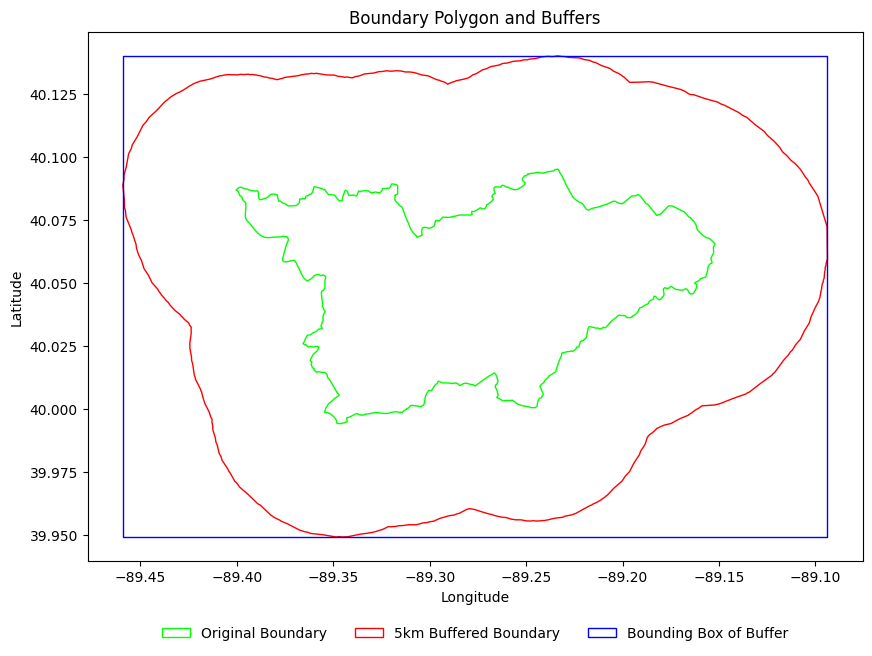

In [54]:
# ----------------------------------------------------------
# Load the GeoJSON files for the watershed boundaries
# ----------------------------------------------------------

# Load the original watershed boundary polygon
geojson_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Original_Boundary.geojson')
boundary_gdf = gpd.read_file(geojson_path)

# Load the 5km buffered watershed boundary polygon
geojson_w_buffer_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_5km_Buffered_Polygon_Boundary.geojson')
boundary_w_buffer_gdf = gpd.read_file(geojson_w_buffer_path)

# Load the bounding box of the 5km buffered area
geojson_buffer_bb_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_BoundingBox_of_5km_Buffered.geojson')
boundary_buffer_bb_gdf = gpd.read_file(geojson_buffer_bb_path)

# ----------------------------------------------------------
# Plot all boundaries and buffers
# ----------------------------------------------------------

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original watershed boundary in lime green
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=1)

# Plot the 5km buffered boundary in red
boundary_w_buffer_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

# Plot the bounding box of the 5km buffered area in blue
boundary_buffer_bb_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# ----------------------------------------------------------
# Create a custom legend
# ----------------------------------------------------------

# Create patches for each boundary/buffer for the legend
boundary_patch = mpatches.Patch(facecolor='none', edgecolor='lime', linewidth=1, label='Original Boundary')
buffer_patch = mpatches.Patch(facecolor='none', edgecolor='red', linewidth=1, label='5km Buffered Boundary')
bb_patch = mpatches.Patch(facecolor='none', edgecolor='blue', linewidth=1, label='Bounding Box of Buffer')

# Add the custom legend outside the plot at the bottom center
ax.legend(handles=[boundary_patch, buffer_patch, bb_patch],
          loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

# ----------------------------------------------------------
# Finalize the plot
# ----------------------------------------------------------

# Set title and axis labels
ax.set_title("Boundary Polygon and Buffers")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display the plot
plt.show()


### 📍 Steps to Get Valid Patch Center Points

1. **Generate Patch Centers**  
- We create evenly spaced patch center points by sliding a window over the raster.  
- The window’s stride and size define how densely we sample patches.  
- We convert the pixel-based center coordinates to geographic coordinates (lon/lat).

2. **Filter Valid Patch Centers**  
- We use the `.within()` method to check which patch centers lie within the watershed boundary polygon.  
- Only these valid points are kept for downstream analysis.

3. **Visualize**  
- The original raster is plotted in grayscale as a spatial backdrop.  
- The watershed boundary (lime) provides spatial context.  
- All patch centers are shown in blue, while valid patch centers (inside the watershed) are highlighted in red.

This ensures that only patches fully contained within the watershed will be used for training or analysis.


/tmp/ipykernel_3060954/3028579547.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  valid_centers_gdf = patch_centers_gdf[patch_centers_gdf.within(boundary_gdf.unary_union)]


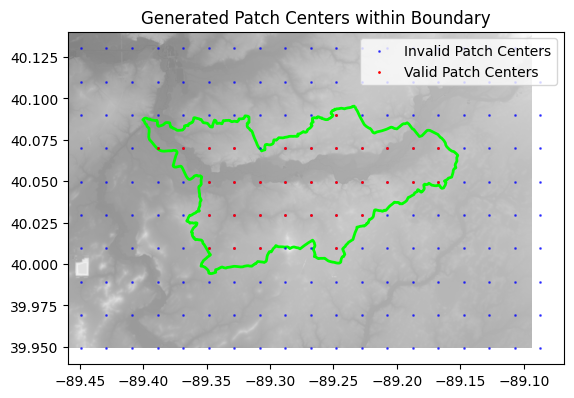

In [53]:
# ----------------------------------------------
# Function to generate patch center points
# ----------------------------------------------
def generate_patch_centers(raster_path, patch_size, stride):
    """
    Generate patch center points (lon, lat) from a raster file.
    
    Parameters:
        raster_path (str): Path to the raster file
        patch_size (int): Size of the patch in pixels
        stride (int): Stride for window movement

    Returns:
        GeoDataFrame: Patch center points in EPSG:4326
    """
    patch_coords = []
    with rasterio.open(raster_path) as ds:
        height, width = ds.height, ds.width
        for r in range(0, height, stride):
            for c in range(0, width, stride):
                center_r = r + patch_size // 2
                center_c = c + patch_size // 2
                lon, lat = ds.xy(center_r, center_c)  # Convert pixel center to lon/lat
                patch_coords.append((lon, lat))
    
    # Create GeoDataFrame of patch center points
    patch_gdf = gpd.GeoDataFrame({'geometry': [Point(lon, lat) for lon, lat in patch_coords]}, crs='EPSG:4326')
    return patch_gdf

# ----------------------------------------------
# Generate all patch center points
# ----------------------------------------------
raster_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif')
patch_size = 224
stride = 224

# Generate patch centers from raster
patch_centers_gdf = generate_patch_centers(raster_path, patch_size, stride)

# ----------------------------------------------
# Filter valid patch centers within boundary
# ----------------------------------------------
# Important: Make sure both are in the same CRS before spatial operation!
# Here we assume boundary_gdf is already in EPSG:4326 (same as patch_centers_gdf)
valid_centers_gdf = patch_centers_gdf[patch_centers_gdf.within(boundary_gdf.unary_union)]

# ----------------------------------------------
# Visualization
# ----------------------------------------------
# Plot boundary
base = boundary_gdf.plot(facecolor='none', edgecolor='lime', linewidth=2)

# Plot raster as a grayscale background
with rasterio.open(raster_path) as ds:
    # Optional: Reproject raster if needed to match boundary CRS (not done here)
    show(ds, ax=base, cmap='gray', alpha=0.5)

# Plot all patch centers in blue
patch_centers_gdf.plot(ax=base, color='blue', markersize=1, alpha=0.6, label='Invalid Patch Centers')

# Plot valid patch centers in red
valid_centers_gdf.plot(ax=base, color='red', markersize=1, alpha=1, label='Valid Patch Centers')

plt.title("Generated Patch Centers within Boundary")
plt.legend(loc='upper right')
plt.show()


## Understanding Patch Footprint in Real-World Size

### Patch Footprint Visualization
Each patch has the same number of pixels (e.g., 224x224), but the real-world footprint depends on raster resolution.
For example:
- 10m raster: 224 x 10m = 2240m real-world size
- 30m raster: 224 x 30m = 6720m real-world size
We will now visualize these real-world footprints!

In [59]:
def extract_resolution_from_filename(filename):
    """
    Extracts the resolution in meters from the raster filename.
    Example filename: DEM_10m_Rect.tif -> returns 10
    """
    match = re.search(r'_(\d+)(m)_', filename)
    if match:
        return int(match.group(1))
    return None  # Return None if no resolution found

def visualize_real_world_patch_footprints(raster_paths, patch_centers_gdf, patch_size):
    """
    Visualizes real-world footprints of the first patch (patch 0) for multiple rasters.

    Parameters:
        raster_paths (list): List of raster file paths
        patch_centers_gdf (GeoDataFrame): GeoDataFrame with patch center points in EPSG:4326
        patch_size (int): Patch size in pixels
    """
    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the watershed boundary (assuming boundary_gdf is already defined)
    boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, label='Boundary')

    # Loop through each raster file
    for raster_path in raster_paths:
        # Extract the resolution from the filename (e.g., 10m, 30m)
        resolution = extract_resolution_from_filename(os.path.basename(raster_path)) or 10  # Default to 10m if not found

        # Use the first valid patch center point
        center_point = patch_centers_gdf.geometry.iloc[0]
        lon, lat = center_point.x, center_point.y

        # Convert the center point to UTM coordinates for accurate real-world (meter) sizing
        transformer_to_utm = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
        utm_x, utm_y = transformer_to_utm.transform(lon, lat)

        # Calculate half the size of the patch in meters
        patch_half_size_m = (patch_size * resolution) / 2

        # Calculate min and max UTM coordinates for the patch footprint
        min_x, max_x = utm_x - patch_half_size_m, utm_x + patch_half_size_m
        min_y, max_y = utm_y - patch_half_size_m, utm_y + patch_half_size_m

        # Convert back to geographic coordinates (lon/lat) for plotting
        transformer_to_latlon = Transformer.from_crs("EPSG:32616", "EPSG:4326", always_xy=True)
        min_lon, min_lat = transformer_to_latlon.transform(min_x, min_y)
        max_lon, max_lat = transformer_to_latlon.transform(max_x, max_y)

        # Create a rectangular polygon (footprint of the patch) in EPSG:4326
        patch_box = box(min_lon, min_lat, max_lon, max_lat)
        patch_gdf = gpd.GeoDataFrame({'geometry': [patch_box]}, crs='EPSG:4326')

        # Choose color based on resolution
        color = 'cyan' if resolution == 5 else \
                'orange' if resolution == 10 else \
                'red' if resolution == 30 else 'purple'

        # Plot the patch footprint
        patch_gdf.plot(ax=ax, facecolor='none', edgecolor=color, linewidth=2, alpha=0.7, label=f'{resolution}m Patch')

    # Plot patch centers for reference
    patch_centers_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.8, label='Patch Center')

    # Final plot styling
    ax.set_title("Real-World Patch Footprints")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    # plt.axis('equal')  # Keep equal aspect ratio for spatial accuracy
    plt.show()


/tmp/ipykernel_3060954/3978261149.py:70: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


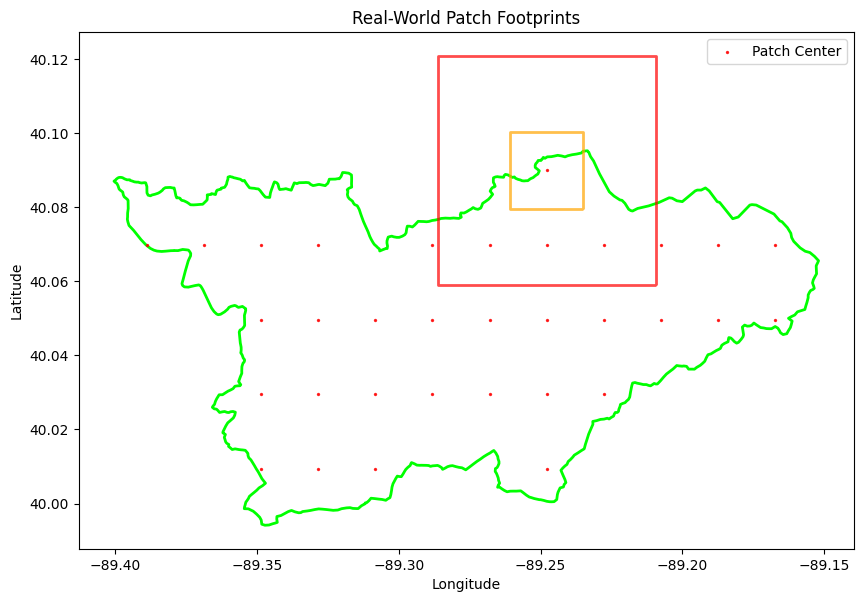

In [60]:
raster_files = [
    os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif'),
    os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif'),
]
visualize_real_world_patch_footprints(raster_files, valid_centers_gdf, patch_size=patch_size)


In [72]:
def visualize_patch_grid_on_raster(raster_path, boundary_gdf, patch_centers_gdf, patch_size, stride):
    """
    Visualizes patch grid footprints on top of the raster and boundary polygon.
    
    Parameters:
        raster_path (str): Path to the raster file
        boundary_gdf (GeoDataFrame): Boundary polygon in EPSG:4326
        patch_centers_gdf (GeoDataFrame): Patch center points in EPSG:4326
        patch_size (int): Patch size in pixels
        stride (int): Stride for window movement
    """
    # Reproject raster to EPSG:4326 to match boundary and patch centers
    with rasterio.open(raster_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:4326',
            'transform': transform,
            'width': width,
            'height': height
        })

        reprojected_raster = np.empty((src.count, height, width), dtype=src.dtypes[0])
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=reprojected_raster[i - 1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:4326',
                resampling=Resampling.nearest
            )

    # Compute raster extent for plotting
    min_lon, max_lat = transform * (0, 0)
    max_lon, min_lat = transform * (width, height)
    extent = (min_lon, max_lon, min_lat, max_lat)

    # Plot raster
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(reprojected_raster[0], cmap='gray', extent=extent, alpha=0.8)

    # Plot the watershed boundary
    boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=1)

    # Plot valid patch centers
    patch_centers_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Patch Centers')

    # Create patch grid footprints (yellow rectangles)
    for center_point in patch_centers_gdf.geometry:
        lon, lat = center_point.x, center_point.y
        # Calculate footprint in lon/lat
        half_pixel_deg_x = (patch_size * src.res[0]) / 2
        half_pixel_deg_y = (patch_size * src.res[1]) / 2
        min_x, max_x = lon - half_pixel_deg_x, lon + half_pixel_deg_x
        min_y, max_y = lat - half_pixel_deg_y, lat + half_pixel_deg_y
        rect = box(min_x, min_y, max_x, max_y)
        patch_gdf = gpd.GeoDataFrame({'geometry': [rect]}, crs='EPSG:4326')
        patch_gdf.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=1, alpha=0.5)

    # Final plot styling
    ax.set_title(f"Patches at {stride}m Resolution (Raster: {os.path.basename(raster_path)})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='lower left', frameon=True)
    ax.set_aspect('equal')
    plt.show()

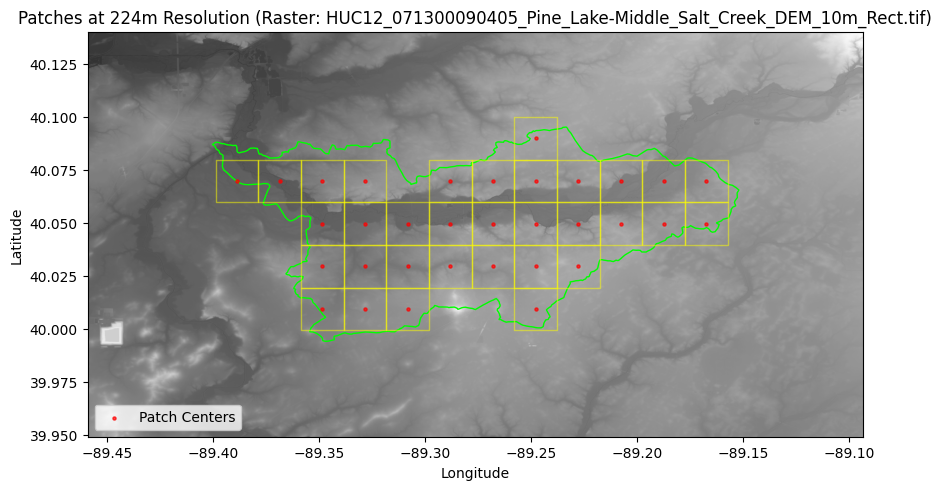

In [74]:
# Example usage
raster_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif') # Replace with actual path
visualize_patch_grid_on_raster(
    raster_path=raster_path,
    patch_centers_gdf=valid_centers_gdf,
    boundary_gdf=boundary_gdf,
    patch_size=patch_size,
    stride=stride
)

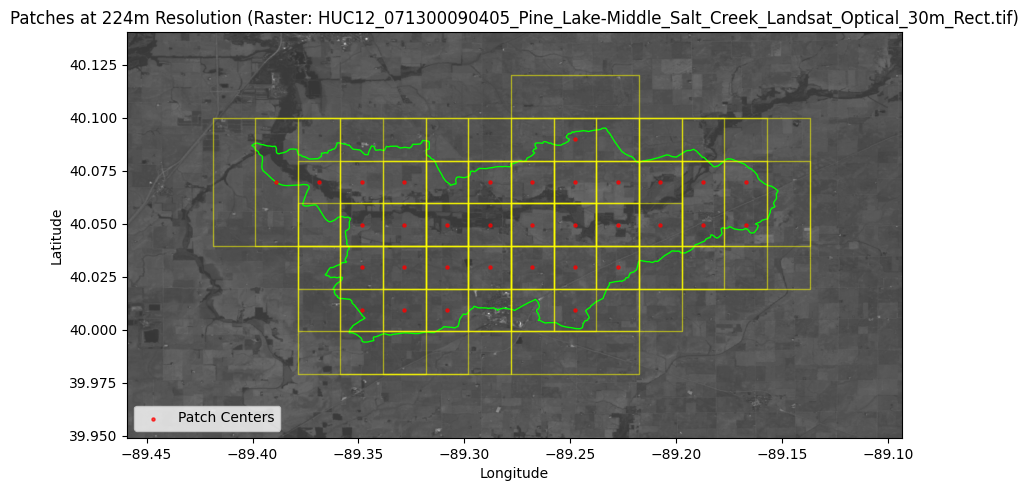

In [73]:
# Example usage
raster_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif') # Replace with actual path
visualize_patch_grid_on_raster(
    raster_path=raster_path,
    patch_centers_gdf=valid_centers_gdf,
    boundary_gdf=boundary_gdf,
    patch_size=patch_size,
    stride=stride
)

In [56]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import numpy as np
import re

def extract_resolution_from_filename(filename):
    match = re.search(r'_(\d+)(m)_', filename)
    if match:
        return int(match.group(1))
    return None

def extract_patch_geographic_extent(raster_path, center_point, patch_size, pad_value=0):
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        width, height = ds.width, ds.height
        crs = ds.crs

        # Convert center point to pixel coordinates
        target_r, target_c = ds.index(center_point.x, center_point.y)

        # Compute top-left window pixel coordinates
        window_r = target_r - patch_size // 2
        window_c = target_c - patch_size // 2
        window = Window(window_c, window_r, patch_size, patch_size)

        # Compute actual window intersection
        full_window = Window(0, 0, width, height)
        actual_window = window.intersection(full_window)

        # Read data for actual window
        data = ds.read(window=actual_window)

        # Pad to desired patch size
        padded_patch = np.full((ds.count, patch_size, patch_size), pad_value, dtype=ds.dtypes[0])
        row_off = max(0, -window_r)
        col_off = max(0, -window_c)
        padded_patch[:, row_off:row_off + actual_window.height, col_off:col_off + actual_window.width] = data

        # Compute geographic extent of the patch
        min_lon, max_lat = transform * (window_c, window_r)
        max_lon, min_lat = transform * (window_c + patch_size, window_r + patch_size)
        extent = (min_lon, max_lon, min_lat, max_lat)

        return padded_patch, extent, crs

def visualize_patch0_extent_side_by_side(raster_paths, valid_centers_gdf, patch_size, pad_value=0):
    fig, axes = plt.subplots(1, len(raster_paths), figsize=(5 * len(raster_paths), 6), constrained_layout=True)

    if len(raster_paths) == 1:
        axes = [axes]

    for ax, raster_path in zip(axes, raster_paths):
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 'Unknown'

        # Use the first valid center point
        center_point = valid_centers_gdf.geometry.iloc[0]

        patch_data, extent, crs = extract_patch_geographic_extent(
            raster_path, center_point, patch_size, pad_value
        )

        # Plot the patch
        if patch_data.shape[0] == 1:
            ax.imshow(patch_data[0], cmap='gray', alpha=0.7, extent=extent)
        else:
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), alpha=0.7, extent=extent)

        ax.set_title(f"{os.path.basename(raster_path)}\nResolution: {resolution}m\nExtent: {np.round(extent, 4)}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    plt.suptitle("Patch 0 from Each Raster (Spatial Extent)", fontsize=16)
    plt.show()


def visualize_patch0_same_scale(raster_paths, valid_centers_gdf, patch_size, pad_value=0):
    # Store patches and their extents
    patches_data = []
    all_extents = []

    for raster_path in raster_paths:
        center_point = valid_centers_gdf.geometry.iloc[0]
        patch_data, extent, crs = extract_patch_geographic_extent(
            raster_path, center_point, patch_size, pad_value
        )
        patches_data.append((patch_data, raster_path))
        all_extents.append(extent)

    # Determine the overall extent for all plots
    min_lon = min(ext[0] for ext in all_extents)
    max_lon = max(ext[1] for ext in all_extents)
    min_lat = min(ext[2] for ext in all_extents)
    max_lat = max(ext[3] for ext in all_extents)
    overall_extent = (min_lon, max_lon, min_lat, max_lat)

    print("✅ Overall extent for visualization:", np.round(overall_extent, 4))

    # Plot all patches side by side with the same scale (extent)
    fig, axes = plt.subplots(1, len(raster_paths), figsize=(5 * len(raster_paths), 6), constrained_layout=True)

    if len(raster_paths) == 1:
        axes = [axes]

    for ax, (patch_data, raster_path) in zip(axes, patches_data):
        resolution = extract_resolution_from_filename(raster_path) or 'Unknown'
        if patch_data.shape[0] == 1:
            ax.imshow(patch_data[0], cmap='gray', alpha=0.7, extent=overall_extent)
        else:
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), alpha=0.7, extent=overall_extent)

        ax.set_title(f"{os.path.basename(raster_path)}\nResolution: {resolution}m")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    plt.suptitle("Patch 0 from Each Raster (Same Scale / Spatial Extent)", fontsize=16)
    plt.show()


def visualize_patches_real_world_extent(raster_paths, patch_centers_gdf, patch_size):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the boundary polygon
    gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, alpha=1.0, label='Boundary')

    for raster_path in raster_paths:
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 10  # default if resolution not in filename

        # Use the first valid center point
        center_point = patch_centers_gdf.geometry.iloc[0]
        lon, lat = center_point.x, center_point.y

        # Convert center point to UTM for accurate meter-based sizes
        transformer_to_utm = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
        utm_x, utm_y = transformer_to_utm.transform(lon, lat)

        # Calculate patch extent in UTM coordinates (in meters)
        patch_half_size_m = (patch_size * resolution) / 2
        min_x = utm_x - patch_half_size_m
        max_x = utm_x + patch_half_size_m
        min_y = utm_y - patch_half_size_m
        max_y = utm_y + patch_half_size_m

        # Convert patch extent back to lon/lat for plotting
        transformer_to_latlon = Transformer.from_crs("EPSG:32616", "EPSG:4326", always_xy=True)
        min_lon, min_lat = transformer_to_latlon.transform(min_x, min_y)
        max_lon, max_lat = transformer_to_latlon.transform(max_x, max_y)

        # Create polygon (as a box) for the patch extent
        patch_box = box(min_lon, min_lat, max_lon, max_lat)
        patch_gdf = gpd.GeoDataFrame({'geometry': [patch_box]}, crs='EPSG:4326')

        # Plot patch box
        color = 'cyan' if resolution == 5 else \
                'orange' if resolution == 10 else \
                'red' if resolution == 20 else \
                'yellow' if resolution == 30 else 'purple'
        patch_gdf.plot(ax=ax, facecolor='none', edgecolor=color, linewidth=2,
                        alpha=0.7, label=f'Patch {resolution}m')

    ax.set_title("Real-World Patch Extents (Accurate Footprints)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='lower left')
    plt.show()

✅ Overall extent for visualization: [-89.2782 -89.2178  40.0598  40.1202]


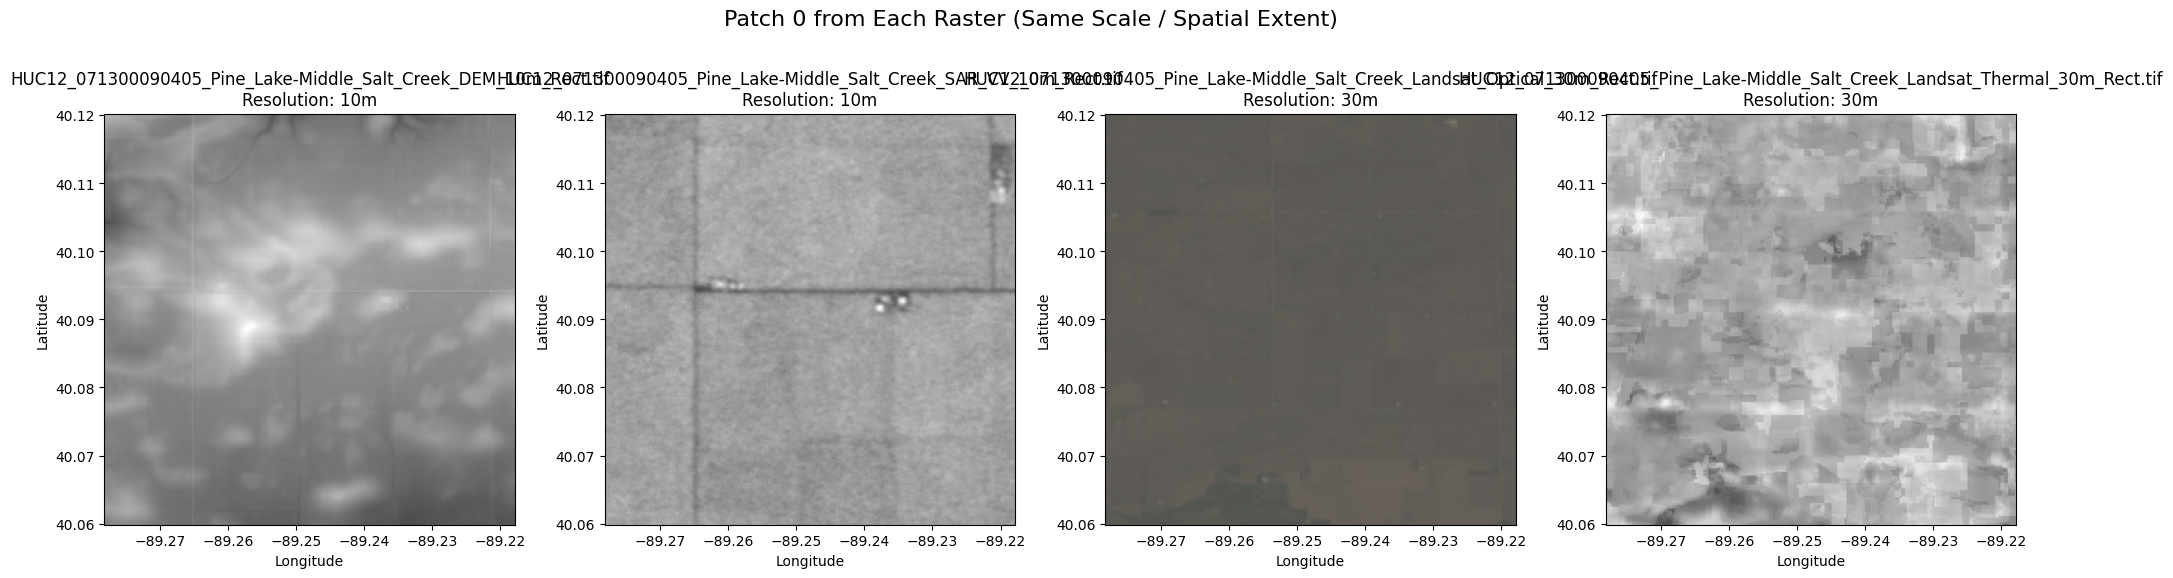

In [55]:
# Example list of raster file paths (update to your raster paths!)
raster_files = [
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_SAR_VV_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Thermal_30m_Rect.tif',
]

# Visualize patch 0 from each raster side by side
visualize_patch0_same_scale(raster_files, patch_centers_gdf, PATCH_SIZE)

In [58]:
import rasterio
from pyproj import Transformer
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np
import re
import os

def extract_resolution_from_filename(filename):
    match = re.search(r'_(\d+)(m)_', filename)
    if match:
        return int(match.group(1))
    return None

def extract_patch_data_and_extent(raster_path, center_point, patch_size, pad_value=0):
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        width, height = ds.width, ds.height

        # Convert center point to pixel coordinates
        target_r, target_c = ds.index(center_point.x, center_point.y)

        # Calculate window
        window_r = target_r - patch_size // 2
        window_c = target_c - patch_size // 2
        window = rasterio.windows.Window(window_c, window_r, patch_size, patch_size)

        # Compute actual intersection window
        full_window = rasterio.windows.Window(0, 0, width, height)
        actual_window = window.intersection(full_window)

        # Read data
        data = ds.read(window=actual_window)

        # Pad data if needed
        padded_patch = np.full((ds.count, patch_size, patch_size), pad_value, dtype=ds.dtypes[0])
        row_off = max(0, -window_r)
        col_off = max(0, -window_c)
        padded_patch[:, row_off:row_off + actual_window.height, col_off:col_off + actual_window.width] = data

        # Calculate real-world extent (lon/lat)
        min_lon, max_lat = transform * (window_c, window_r)
        max_lon, min_lat = transform * (window_c + patch_size, window_r + patch_size)
        extent = (min_lon, max_lon, min_lat, max_lat)

        return padded_patch, extent

def visualize_real_world_patch_data(raster_paths, patch_centers_gdf, patch_size, pad_value=0):
    fig, axes = plt.subplots(1, len(raster_paths), figsize=(6 * len(raster_paths), 6), constrained_layout=True)

    if len(raster_paths) == 1:
        axes = [axes]

    # Load the boundary polygon
    geojson_path = '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Original_Boundary.geojson'
    gdf = gpd.read_file(geojson_path)
    if gdf.crs is None:
        gdf.set_crs('EPSG:4326', inplace=True)

    for ax, raster_path in zip(axes, raster_paths):
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 10

        # Use first valid center point
        center_point = patch_centers_gdf.geometry.iloc[0]
        lon, lat = center_point.x, center_point.y

        # Extract patch data and geographic extent
        patch_data, extent = extract_patch_data_and_extent(
            raster_path, center_point, patch_size, pad_value
        )

        # Plot the patch data in real-world extent
        if patch_data.shape[0] == 1:
            ax.imshow(patch_data[0], cmap='gray', extent=extent, alpha=0.7)
        else:
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), extent=extent, alpha=0.7)

        # Plot the boundary for context
        gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, alpha=1.0, label='Boundary')

        # Plot patch center
        ax.scatter(lon, lat, color='red', s=20, label='Patch Center')

        ax.set_title(f"{os.path.basename(raster_path)}\nResolution: {resolution}m\nExtent: {np.round(extent, 5)}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend(loc='lower left')

    plt.suptitle("Real-World Spatial Extent of Patch 0 Data (Aligned Footprint)", fontsize=16)
    plt.show()


/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legen

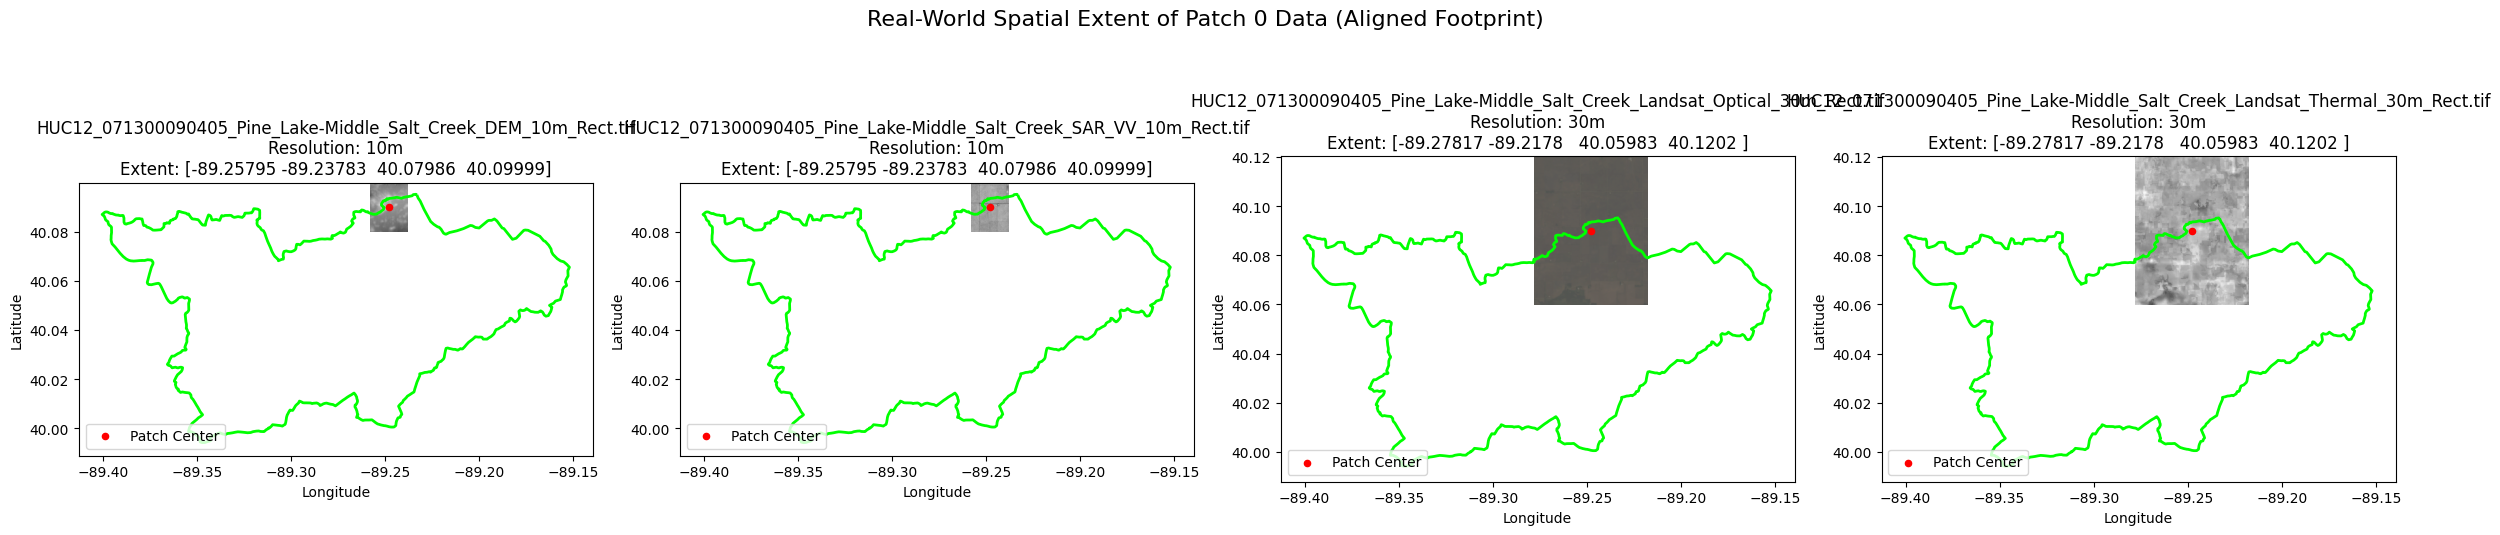

In [59]:
# Example list of raster file paths (update to your raster paths!)
raster_files = [
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_SAR_VV_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Thermal_30m_Rect.tif',
]

# Visualize patch 0 from each raster side by side
visualize_real_world_patch_data(raster_files, patch_centers_gdf, PATCH_SIZE)